In [ ]:
! pip install backtrader

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pandas as pd
from backtrader.feeds import PandasData
import numpy as np

In [ ]:
class MACrossOverStrategy(bt.Strategy):
    lines = ('signal',)
    params = (
        ('period1', 14),
        ('period2', 7),
        ('takeProfit', 0.01)
    )

    def __init__(self):
        self.sma1 = bt.indicators.SMA(period=self.p.period1)
        self.sma2 = bt.indicators.SMA(period=self.p.period2)
        # To keep track of orders
        self.isInPosition = False
        self.lastPrice = None
    
    def next(self):
      closePrice = self.data.lines.close
      if not self.isInPosition and self.sma2[0] > self.sma1[0]:
        self.lastPrice = closePrice
        self.buy()
      elif self.isInPosition and (self.sma2[0] < self.sma1[0] or (closePrice - self.lastPrice) / self.lastPrice > self.p.takeProfit):
        self.sell()
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
                self.isInPosition = True
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
                self.isInPosition = False

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Rejected]:
            self.log('Order Canceled/Rejected')
        elif order.status in [order.Margin]:
            pass
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def stop(self):
        self.log('(MA Period %2d / %2d) && TP %.4f Ending Value %.2f' %
                 (self.params.period1, self.params.period2, self.params.takeProfit, self.broker.getvalue()))

In [ ]:
def addCSV(csvFile):
    global data
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, csvFile)
    # Create a Data Feed
    dataframe = pd.read_csv(
        datapath,
        skiprows=0,
        header=0,
        parse_dates=False,
        index_col=None
    )
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], infer_datetime_format=True)
    dataframe = dataframe.sort_values(by='Date', ascending=True)
    dataframe = dataframe[:250]
    return PandasData(
        dataname=dataframe,
        datetime='Date',
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume"
    )

In [ ]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
# cerebro.addstrategy(MACrossOverStrategy)

# Optimize strategy
strats = cerebro.optstrategy(
    MACrossOverStrategy,
    period1=range(10, 50),
    period2=range(5, 10),
    takeProfit=np.arange(0.001, 0.1, 0.001)
)

# data1 = addCSV('/content/drive/MyDrive/crypto-data/gemini_BTCUSD_2020_1min.csv')
# # Add the Data Feed to Cerebro
# cerebro.adddata(data1)

data2 = addCSV('/content/drive/MyDrive/crypto-data/gemini_ETHUSD_2020_1min.csv')
# Add the Data Feed to Cerebro
cerebro.adddata(data2, name="ETHUSD")

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Set transactional commissions
cerebro.broker.setcommission(0.02)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

"""
The sample Signal will always be either > 0 and < 0
This would lead to a continuous generation of orders that would produce 2 situations:
Accumulation: even if already in the market, the signals would produce new orders which would increase the possition in the market
Concurrency: new orders would be generated without waiting for the execution of other orders
To avoid this the default behavior is:
"""
cerebro.signal_accumulate(False)
cerebro.signal_concurrent(False)

# default sizer for strategies
cerebro.addsizer(bt.sizers.SizerFix, stake=100)

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2020-01-01, BUY EXECUTED, 128.09
2020-01-01, SELL EXECUTED, 128.26
2020-01-01, BUY EXECUTED, 128.22
2020-01-01, SELL EXECUTED, 128.53
2020-01-01, BUY EXECUTED, 128.53
2020-01-01, SELL EXECUTED, 129.98
2020-01-01, BUY EXECUTED, 129.95
2020-01-01, SELL EXECUTED, 130.23
2020-01-01, BUY EXECUTED, 130.35
2020-01-01, SELL EXECUTED, 130.12
2020-01-01, BUY EXECUTED, 130.30
2020-01-01, SELL EXECUTED, 129.94
2020-01-01, BUY EXECUTED, 129.83
2020-01-01, SELL EXECUTED, 129.55
2020-01-01, BUY EXECUTED, 129.83
2020-01-01, SELL EXECUTED, 129.56
2020-01-01, (MA Period 14 /  7) && TP 0.0100 Ending Value 95964.46
Final Portfolio Value: 95964.46


<IPython.core.display.Javascript object>

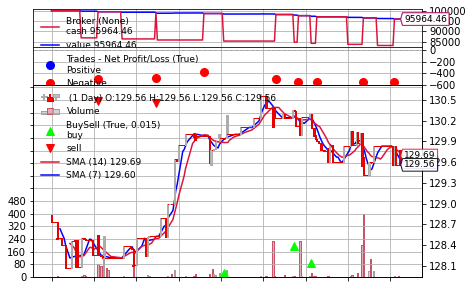

In [ ]:
plots = cerebro.plot(numfigs=1, width=10, height=30, figsize=(10,30), style="candle", iplot=True, tight=True)